# Network Analysis

This notebook supports the analysis part of our project. We assume that you already have a DuckDB instance filled with necessary tables. If not, please visit `setup.ipynb`.

Let's start with basic imports and connecting to our database.

In [1]:
import duckdb
import pandas as pd

# Connect to a persistent DuckDB database file
conn = duckdb.connect("imdb.duckdb")

As mentioned in the setup, we are dealing with 7 tables:
1. `name_basics`
2. `title_akas`
3. `title_basics`
4. `title_crew`
5. `title_episode`
6. `title_principals`
7. `title_ratings`

The following query shows a detailed overview about our schema.

In [2]:
df = conn.execute("""
SELECT table_name, column_name, data_type
FROM information_schema.columns
WHERE table_schema = 'main'
ORDER BY table_name, ordinal_position;
""").df()

display(df)

,table_name,column_name,data_type
0,name_basics,nconst,VARCHAR
1,name_basics,primary_name,VARCHAR
2,name_basics,birth_year,INTEGER
3,name_basics,death_year,INTEGER
4,name_basics,primary_profession,VARCHAR[]
5,name_basics,known_for_titles,VARCHAR[]
6,title_akas,title_id,VARCHAR
7,title_akas,CAST(ordering AS INTEGER),INTEGER
8,title_akas,title,VARCHAR
9,title_akas,region,VARCHAR


The following cell lists all titles and actors along with other interesting information (average rating, runtime, country, etc.). This should be useful for analysis.

In [3]:
df = conn.execute("""
    SELECT 
        tb.tconst,
        tb.primary_title AS movie_title,
        tb.start_year,
        tb.runtime_minutes,
        tb.genres,
        tr.average_rating,
        tr.num_votes,
        nb.primary_name AS actor_name,
        nb.birth_year,
        nb.primary_profession,
        tp.category,
        tp.characters,
        ta.region
    FROM title_basics tb
    JOIN title_ratings tr 
        ON tb.tconst = tr.tconst
    JOIN title_principals tp
        ON tb.tconst = tp.tconst
    JOIN name_basics nb
        ON tp.nconst = nb.nconst
    JOIN title_akas ta
        ON tb.tconst = ta.title_id
    WHERE tb.title_type = 'movie'
        AND tb.start_year between 2010 and 2024
        AND ta.region = 'US'
        AND tp.category IN ('actor', 'actress')
        AND tb.genres IS NOT NULL AND array_length(genres) > 0
        AND tb.runtime_minutes IS NOT NULL AND tb.runtime_minutes > 15
    ORDER BY tr.average_rating DESC, tr.num_votes DESC
""").df()

display(df.head(10))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,tconst,movie_title,start_year,runtime_minutes,genres,average_rating,num_votes,actor_name,birth_year,primary_profession,category,characters,region
0,tt15461714,King B.'s Hate... Love,2021,85,[Drama],10.0,14,King B.,<NA>,"[actor, director, producer]",actor,"[""Royal T.""]",US
1,tt15461714,King B.'s Hate... Love,2021,85,[Drama],10.0,14,Brandon Glover,<NA>,[actor],actor,"[""Chump""]",US
2,tt15461714,King B.'s Hate... Love,2021,85,[Drama],10.0,14,Oz Man,<NA>,[actor],actor,"[""Ant""]",US
3,tt15461714,King B.'s Hate... Love,2021,85,[Drama],10.0,14,Brian 'Da Wildcat' Smith,<NA>,"[actor, writer, producer]",actor,"[""Grimmy""]",US
4,tt15461714,King B.'s Hate... Love,2021,85,[Drama],10.0,14,Damn Fool,<NA>,"[actor, writer]",actor,"[""Ed""]",US
5,tt15461714,King B.'s Hate... Love,2021,85,[Drama],10.0,14,Cookie Pearl Reid,<NA>,"[actress, miscellaneous]",actress,"[""Susan""]",US
6,tt15461714,King B.'s Hate... Love,2021,85,[Drama],10.0,14,Brandall Cole,<NA>,"[actor, writer, director]",actor,"[""Robber""]",US
7,tt15461714,King B.'s Hate... Love,2021,85,[Drama],10.0,14,Maria Geiger,<NA>,[actress],actress,"[""Donna""]",US
8,tt15461714,King B.'s Hate... Love,2021,85,[Drama],10.0,14,Tiphanie Nichole Rae,<NA>,[actress],actress,"[""Rachael""]",US
9,tt15461714,King B.'s Hate... Love,2021,85,[Drama],10.0,14,Olivia Gant,<NA>,[actress],actress,"[""Eve""]",US


### Exploratory Data Analysis
Below is a maze of analysis cells. Some cells might make it to the final report, while other stuff is simply "cool to display".

In [4]:
#!pip install networkx
len(df)

732949

It appears that the dataset had some duplicate elements. We need to drop them and keep only one instance.

In [5]:
df.drop_duplicates(subset=['tconst', 'actor_name', 'category'], inplace=True)
len(df)

613933

In the cell below, we create a collaboration network graph using networkx where nodes are actors and edges represent collaborations in movies. For each pair of actors that appear in the same movie, we add an edge between them with a weight indicating how many times they've worked together, while also storing the actor names as node attributes.

In [6]:
import networkx as nx
from itertools import combinations

G_collabs = nx.Graph()

for tconst, group in df.groupby('tconst'):
    actors = group['actor_name'].tolist()
    for actor1, actor2 in combinations(actors, 2):
        if actor1 == actor2:
            continue
        # Add nodes excplicitly to add name attributes
        if not G_collabs.has_node(actor1):
            G_collabs.add_node(actor1, name=actor1)
        if not G_collabs.has_node(actor2):
            G_collabs.add_node(actor2, name=actor2)
        # Add edge with weight
        if G_collabs.has_edge(actor1, actor2):
            G_collabs[actor1][actor2]['weight'] += 1
        else:
            G_collabs.add_edge(actor1, actor2, weight=1)

In the cell below, we analyze actor statistics by:
1. Counting how many movies each actor appears in
2. Calculating total collaborations (sum of edge weights) for each actor
3. Calculating unique collaborations (number of different actors worked with) for each actor
4. Creating a dataframe with these metrics and displaying the top 10 most prolific actors

In [7]:
# Group by actor_name and count the number of movies
actor_movie_counts = df.groupby('actor_name').size().reset_index(name='movie_count')

# Calculate total collaborations per actor
collaboration_counts = {
    node: sum(data['weight'] for _, _, data in G_collabs.edges(node, data=True))
    for node in G_collabs.nodes
}

# Calculate unique collaborations (degree) per actor
unique_collabs = {
    node: len(list(G_collabs.neighbors(node)))
    for node in G_collabs.nodes
}

# Create dataframe with all metrics
actor_stats = pd.DataFrame({
    'actor_name': actor_movie_counts['actor_name'],
    'movie_count': actor_movie_counts['movie_count'],
    'total_collaborations': actor_movie_counts['actor_name'].map(collaboration_counts),
    'unique_collaborations': actor_movie_counts['actor_name'].map(unique_collabs)
})

# Sort by movie count and get top 10
top_10_actors = actor_stats.sort_values('movie_count', ascending=False).head(10)

# Display the results
display(top_10_actors)

,actor_name,movie_count,total_collaborations,unique_collaborations
91136,Eric Roberts,272,2394.0,2133.0
69892,Danny Trejo,106,943.0,835.0
292835,Tom Sizemore,105,928.0,827.0
309978,Yogi Babu,104,874.0,558.0
299887,Vennela Kishore,103,907.0,484.0
217054,Nassar,99,875.0,580.0
205488,Michael Madsen,97,844.0,781.0
238047,Prakash Raj,87,763.0,508.0
205816,Michael Paré,86,771.0,675.0
284980,Tanikella Bharani,85,740.0,476.0


In the cell below, we calculate total collaborations (sum of edge weights) and unique collaborations (number of different actors worked with) for each actor in the network. We identify and analyze the two most connected actors based on total collaborations, printing their:
- Total number of collaborations (weighted connections)
- Number of unique actors they've collaborated with

In [8]:
# Calculate total collaborations per actor (sum of edge weights)
collaboration_counts = {
    node: sum(data['weight'] for _, _, data in G_collabs.edges(node, data=True))
    for node in G_collabs.nodes
}

sorted_actors = sorted(collaboration_counts.items(), key=lambda x: x[1], reverse=True)
most_connected_actor, total_collaborations = sorted_actors[0]
second_connected_actor, second_total_collaborations = sorted_actors[1]

#most_connected_actor = max(collaboration_counts, key=collaboration_counts.get)
#total_collaborations = collaboration_counts[most_connected_actor]

# Find how many unique actors they collaborated with (degree)
first_unique_collaborators = len(list(G_collabs.neighbors(most_connected_actor)))
second_unique_collaborators = len(list(G_collabs.neighbors(second_connected_actor)))

print(f"Most connected actor: {most_connected_actor}")
print(f"Total collaborations: {total_collaborations}")
print(f"Unique actors collaborated with: {first_unique_collaborators}")

print(f"Second most connected actor: {second_connected_actor}")
print(f"Total collaborations: {second_total_collaborations}")
print(f"Unique actors collaborated with: {second_unique_collaborators}")

Most connected actor: Eric Roberts
Total collaborations: 2394
Unique actors collaborated with: 2133
Second most connected actor: Danny Trejo
Total collaborations: 943
Unique actors collaborated with: 835


In the cell below, we create a DataFrame that maps actor names to their total number of collaborations (sum of edge weights) by:
1. Converting the collaboration_counts dictionary to a DataFrame
2. Resetting the index to turn actor names into a column

In [9]:
# Calculate total collaborations per actor (sum of edge weights)
collaboration_counts = {
    node: sum(data['weight'] for _, _, data in G_collabs.edges(node, data=True))
    for node in G_collabs.nodes
}

sorted_actors = sorted(collaboration_counts.items(), key=lambda x: x[1], reverse=True)
most_connected_actor, total_collaborations = sorted_actors[0]
second_connected_actor, second_total_collaborations = sorted_actors[1]

#most_connected_actor = max(collaboration_counts, key=collaboration_counts.get)
#total_collaborations = collaboration_counts[most_connected_actor]

# Find how many unique actors they collaborated with (degree)
first_unique_collaborators = len(list(G_collabs.neighbors(most_connected_actor)))
second_unique_collaborators = len(list(G_collabs.neighbors(second_connected_actor)))

print(f"Most connected actor: {most_connected_actor}")
print(f"Total collaborations: {total_collaborations}")
print(f"Unique actors collaborated with: {first_unique_collaborators}")

print(f"Second most connected actor: {second_connected_actor}")
print(f"Total collaborations: {second_total_collaborations}")
print(f"Unique actors collaborated with: {second_unique_collaborators}")

Most connected actor: Eric Roberts
Total collaborations: 2394
Unique actors collaborated with: 2133
Second most connected actor: Danny Trejo
Total collaborations: 943
Unique actors collaborated with: 835


In the cell below, we combine the movie count data with collaboration count data by:
1. Sorting actors by movie count
2. Calculating collaboration counts from the graph edges
3. Converting collaboration counts to a DataFrame
4. Merging the movie count and collaboration count DataFrames

In [10]:
# Sort actors by movie count
sorted_actors = actor_movie_counts.sort_values('movie_count', ascending=False).reset_index(drop=True)

# Calculate collaboration counts
collaboration_counts = {
    node: sum(data['weight'] for _, _, data in G_collabs.edges(node, data=True))
    for node in G_collabs.nodes
}

# Convert collaboration counts dict to DataFrame
collab_df = pd.DataFrame.from_dict(collaboration_counts, orient='index', columns=['collab_count']).reset_index(names=["actor_name"])

# Join the DataFrames
combined_df = sorted_actors.merge(collab_df, on='actor_name', how='outer')
combined_df.sort_values(by="movie_count", ascending=False)

,actor_name,movie_count,collab_count
91136,Eric Roberts,272,2394.0
69892,Danny Trejo,106,943.0
292835,Tom Sizemore,105,928.0
309978,Yogi Babu,104,874.0
299887,Vennela Kishore,103,907.0
...,...,...,...
8,'Fon' Saowalak Mala,1,9.0
10,'Glider' Bob Saunders,1,4.0
13,'Pizza' Venkatesh,1,9.0
15,'Punnagai Poo' Geetha,1,9.0


In the cell below, we analyze the top 5 actors by movie count to understand their:
- Total number of collaborations (weighted sum of all collaborations)
- Number of unique collaborators they've worked with
- Total number of movies they've appeared in

This helps us understand if actors who appear in many movies tend to work with the same group repeatedly or with diverse groups of actors.

In [11]:
# Get top 5 actors by collaboration count
top_5_actors = sorted_actors.head(5).itertuples()

# Create list to store results
results = []

for actor in top_5_actors:
    actor_name = actor.actor_name
    
    # Get unique collaborators
    collaborators = list(G_collabs.neighbors(actor_name))
    unique_collabs = len(collaborators)
    
    # Get total collaborations
    collab_count = collaboration_counts[actor_name]
    
    # Get movie count 
    movie_count = actor.movie_count
    
    results.append((actor_name, collab_count, unique_collabs, movie_count))

# Display results
for actor_name, collab_count, unique_collabs, movie_count in results:
    print(f"{actor_name}:")
    print(f"  Total collaborations: {collab_count}")
    print(f"  Unique collaborators: {unique_collabs}")
    print(f"  Number of movies: {movie_count}")
    print()

Eric Roberts:
  Total collaborations: 2394
  Unique collaborators: 2133
  Number of movies: 272

Danny Trejo:
  Total collaborations: 943
  Unique collaborators: 835
  Number of movies: 106

Tom Sizemore:
  Total collaborations: 928
  Unique collaborators: 827
  Number of movies: 105

Yogi Babu:
  Total collaborations: 874
  Unique collaborators: 558
  Number of movies: 104

Vennela Kishore:
  Total collaborations: 907
  Unique collaborators: 484
  Number of movies: 103



And the highest collaboration count belongs to...

In [12]:
max(collaboration_counts, key=collaboration_counts.get)

'Eric Roberts'

Looking at the output above, we can see that Scarlett Johansson has the highest number of collaborations. This makes sense given her prominent role in major blockbuster films like the Marvel movies, which tend to have large ensemble casts. Next, we'll analyze the network using PageRank to identify influential actors.

In [13]:
# PageRank as a measure of influence
pagerank = nx.pagerank(G_collabs, weight='weight')
nx.set_node_attributes(G_collabs, pagerank, name='pagerank')

Below we categorize actors into tiers (A-list through D-list) based on their PageRank scores using quartiles. Each tier contains 25% of actors - the top 25% are A-list, next 25% are B-list, and so on. We also add actor names and sort by PageRank to see who the most influential actors are.

In [14]:
import numpy as np

# Convert to DataFrame for ranking
centrality_df = pd.DataFrame.from_dict(pagerank, orient='index', columns=['pagerank'])
centrality_df['tier'] = pd.qcut(centrality_df['pagerank'], q=4, labels=['D-list', 'C-list', 'B-list', 'A-list'])
# Add actor names from the graph as a column
centrality_df['name'] = centrality_df.index.map(lambda node: G_collabs.nodes[node]['name'])
# Preview results
centrality_df.sort_values('pagerank', ascending=False).head(10)


,pagerank,tier,name
Eric Roberts,0.000317,A-list,Eric Roberts
Tom Sizemore,0.000114,A-list,Tom Sizemore
Danny Trejo,0.000111,A-list,Danny Trejo
Michael Madsen,0.000109,A-list,Michael Madsen
Lloyd Kaufman,0.000099,A-list,Lloyd Kaufman
Michael Paré,0.000092,A-list,Michael Paré
Dean Cain,0.000086,A-list,Dean Cain
Bill Oberst Jr.,0.000084,A-list,Bill Oberst Jr.
Maria Olsen,0.000080,A-list,Maria Olsen
Richard Riehle,0.000076,A-list,Richard Riehle


Looking at the results above, Eric Roberts emerges as the most central actor according to PageRank, followed by other prolific character actors like Tom Sizemore, Michael Madsen and Danny Trejo. This is interesting as these actors, while not necessarily Hollywood A-listers in the traditional sense, have appeared in many films and worked with many different actors throughout their careers. The next visualization will show the network of connections between the top 50 actors.

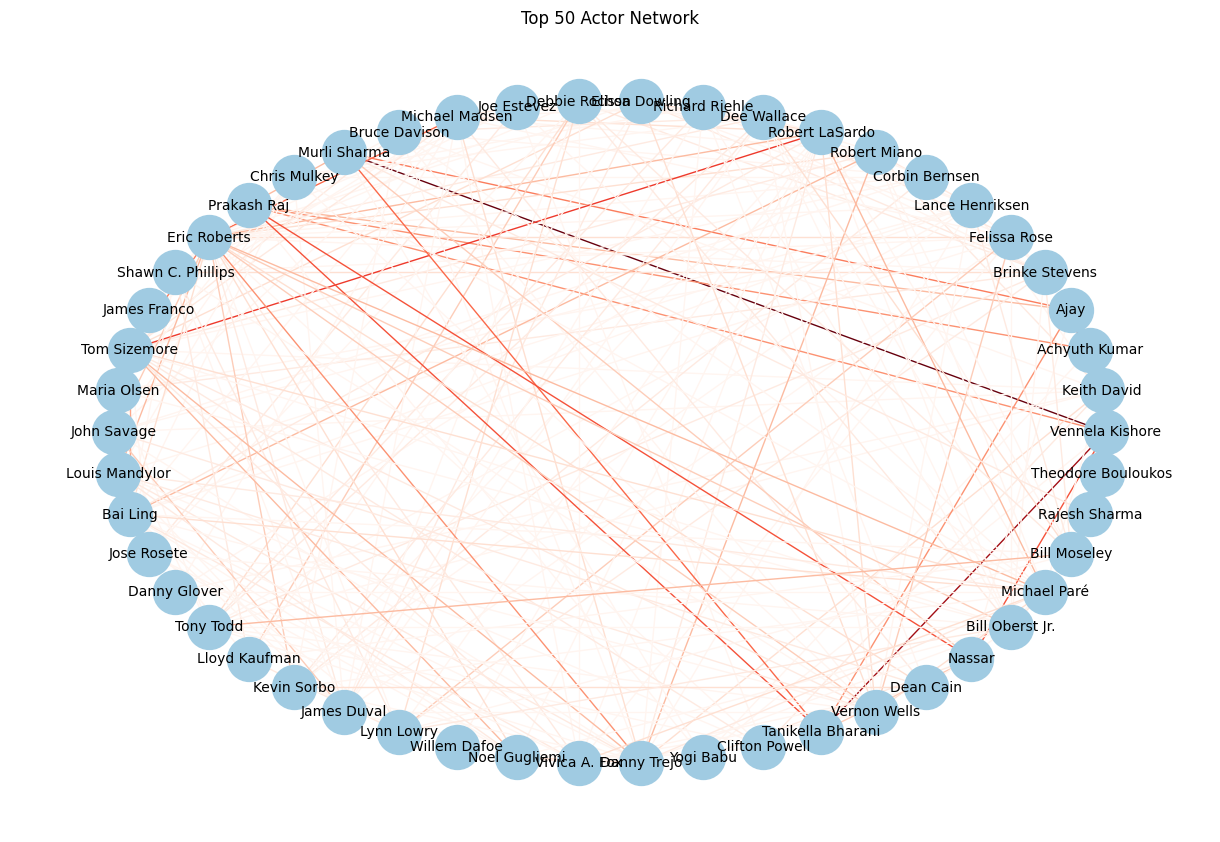

In [15]:
import matplotlib.pyplot as plt

top_actors = centrality_df.sort_values('pagerank', ascending=False).head(50).index
H = G_collabs.subgraph(top_actors)

plt.figure(figsize=(12, 8))
#pos = nx.spring_layout(H, k=0.5, seed=42)
#pos = nx.fruchterman_reingold_layout(H, seed=42)
#pos = nx.random_layout(H, seed=42)
pos = nx.circular_layout(H)
edges,weights = zip(*nx.get_edge_attributes(H,'weight').items())
# Vaja timmida visualiseerimist
options = {
    "node_color": "#A0CBE2",
    "edge_color": weights,
    "edgelist": edges,
    #"width": weights,
    "edge_cmap": plt.cm.Reds,
    "with_labels": True,
    "labels": {n: G_collabs.nodes[n]['name'] for n in H.nodes()},
    "node_size": 1000,
    "font_size": 10
}
nx.draw(H, pos, **options)
plt.title("Top 50 Actor Network")
plt.show()


The visualization above shows the network of connections between the top 50 actors according to PageRank centrality. The nodes represent actors and edges represent collaborations between them, with edge colors indicating the number of collaborations (darker red means more collaborations). The circular layout helps visualize the interconnectedness of these top actors. Next, we'll create a new graph that takes into account the average ratings of movies that actors collaborated in, to analyze "star power" rather than just number of collaborations.

In [16]:
def get_movies_by_actor_pair(actor1, actor2, df):
    # Filter rows where both actors appear in the same movie
    movies_together = df[df['actor_name'].isin([actor1, actor2])]
    movies_together = movies_together.groupby('tconst').filter(lambda x: len(x['actor_name'].unique()) > 1)
    return movies_together[['tconst', 'movie_title', 'average_rating']].drop_duplicates()

# Example usage
actor1 = "Samuel L. Jackson"
actor2 = "Scarlett Johansson"
# Get movies where both actors appeared together
movies = get_movies_by_actor_pair(actor1, actor2, df)
print(movies)

           tconst                          movie_title  average_rating
51695   tt1843866  Captain America: The Winter Soldier             7.7
89571   tt2395427              Avengers: Age of Ultron             7.3
149384  tt1228705                           Iron Man 2             6.9


The cell below creates a new graph G_starPower that takes into account the average ratings of movies that actors collaborated in. For each movie, it creates edges between all pairs of actors in that movie, with the edge weight being the average rating of the movie. If two actors have collaborated in multiple movies, their edge weight is updated to be the average rating across all their collaborations. This allows us to analyze "star power" by considering not just the number of collaborations but also the quality/success of those collaborations through movie ratings.

In [17]:
import networkx as nx
from itertools import combinations

G_starPower = nx.Graph()

for tconst, group in df.groupby('tconst'):
    actors = group['actor_name'].tolist()
    avg_rating = group['average_rating'].iloc[0]
    for actor1, actor2 in combinations(actors, 2):
        if actor1 == actor2:
            continue
        # Add nodes excplicitly to add name attributes
        if not G_starPower.has_node(actor1):
            G_starPower.add_node(actor1, name=actor1)
        if not G_starPower.has_node(actor2):
            G_starPower.add_node(actor2, name=actor2)
        # Add edge with weight
        if G_starPower.has_edge(actor1, actor2):
            G_starPower[actor1][actor2]['total_rating'] += avg_rating
            G_starPower[actor1][actor2]['movie_count'] += 1
             # Update the weighted average rating
            G_starPower[actor1][actor2]['weight'] = (
                G_starPower[actor1][actor2]['total_rating'] / G_starPower[actor1][actor2]['movie_count']
            )
        else:
            G_starPower.add_edge(actor1, actor2, total_rating=avg_rating, movie_count=1, weight=avg_rating)

The cell below calculates PageRank centrality scores for each actor in the network, where edge weights are based on the average movie ratings. This helps identify influential actors not just by number of collaborations, but by the quality/ratings of their collaborative work. The actors are then categorized into tiers (A-list through D-list) based on their PageRank scores.

In [18]:
import numpy as np

# PageRank as a measure of influence
pagerank = nx.pagerank(G_starPower, weight='weight')
nx.set_node_attributes(G_starPower, pagerank, name='pagerank')
# Convert to DataFrame for ranking
centrality_df = pd.DataFrame.from_dict(pagerank, orient='index', columns=['pagerank'])
centrality_df['tier'] = pd.qcut(centrality_df['pagerank'], q=4, labels=['D-list', 'C-list', 'B-list', 'A-list'])
# Add actor names from the graph as a column
centrality_df['name'] = centrality_df.index.map(lambda node: G_starPower.nodes[node]['name'])
# Preview results
centrality_df.sort_values('pagerank', ascending=False).head(10)


,pagerank,tier,name
Eric Roberts,0.000272,A-list,Eric Roberts
Tom Sizemore,0.000097,A-list,Tom Sizemore
Danny Trejo,0.000095,A-list,Danny Trejo
Lloyd Kaufman,0.000094,A-list,Lloyd Kaufman
Michael Madsen,0.000093,A-list,Michael Madsen
Bill Oberst Jr.,0.000075,A-list,Bill Oberst Jr.
Michael Paré,0.000075,A-list,Michael Paré
Dean Cain,0.000072,A-list,Dean Cain
Maria Olsen,0.000072,A-list,Maria Olsen
Richard Riehle,0.000071,A-list,Richard Riehle


The cell below visualizes the network of the top 50 actors by PageRank centrality. The nodes represent actors and edges represent collaborations, with edge colors indicating the average rating of their collaborations. The layout is circular for better readability.

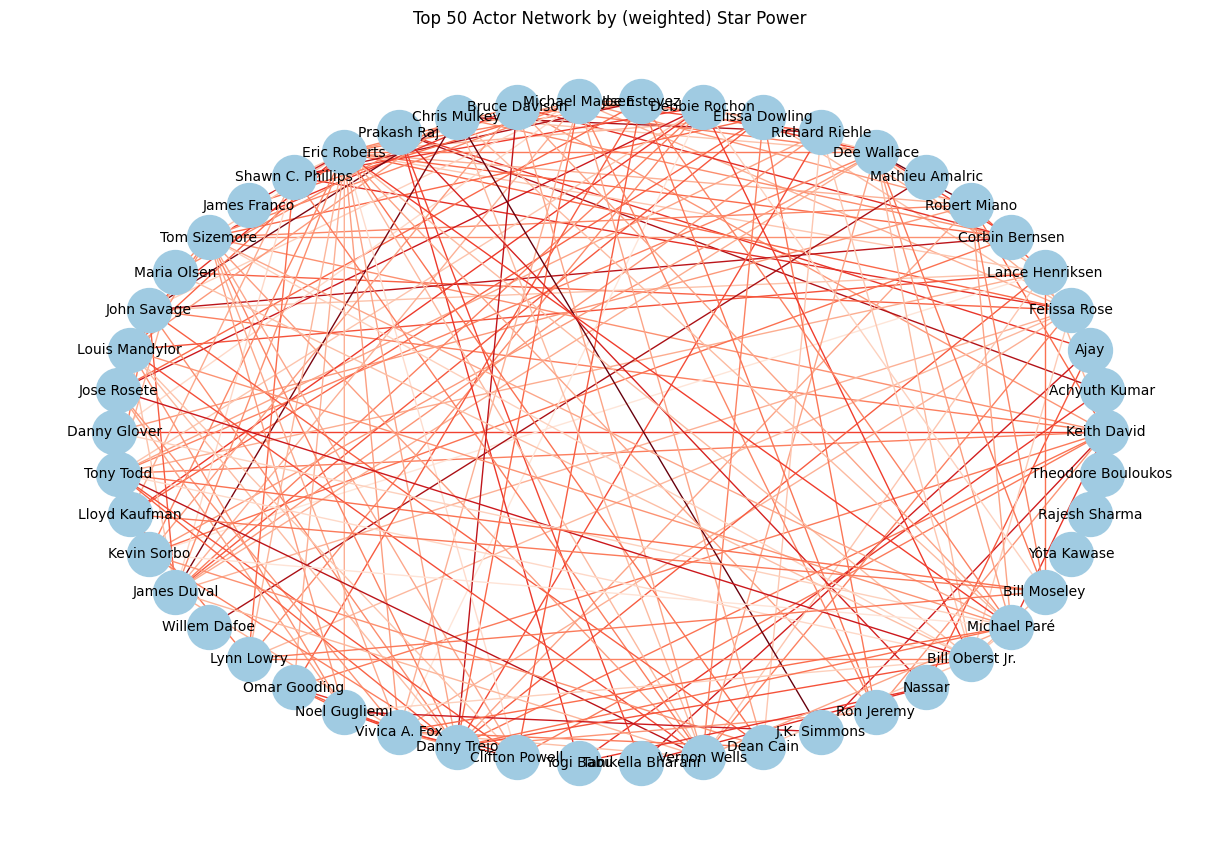

In [19]:
import matplotlib.pyplot as plt

top_actors = centrality_df.sort_values('pagerank', ascending=False).head(50).index
H = G_starPower.subgraph(top_actors)

plt.figure(figsize=(12, 8))
#pos = nx.spring_layout(H, k=0.5, seed=42)
#pos = nx.fruchterman_reingold_layout(H, seed=42)
#pos = nx.random_layout(H, seed=42)
pos = nx.circular_layout(H)
edges,weights = zip(*nx.get_edge_attributes(H,'weight').items())
# Vaja timmida visualiseerimist
options = {
    "node_color": "#A0CBE2",
    "edge_color": weights,
    "edgelist": edges,
    #"width": weights,
    "edge_cmap": plt.cm.Reds,
    "with_labels": True,
    "labels": {n: G_starPower.nodes[n]['name'] for n in H.nodes()},
    "node_size": 1000,
    "font_size": 10
}
nx.draw(H, pos, **options)
plt.title("Top 50 Actor Network by (weighted) Star Power")
plt.show()


Following cell helps us see the movies between two actors.

In [20]:
movies = get_movies_by_actor_pair("Dee Wallace", "Robert Miano", df)
print(movies)

          tconst movie_title  average_rating
18398  tt1390538   Cage Free             8.4


The cell below calculates PageRank centrality for each actor in the network, assigns them to tiers (A-list through D-list) based on their PageRank scores, and displays the top 10 most central actors. PageRank is used here as a measure of an actor's influence and star power in the collaboration network.

In [21]:
import numpy as np

# PageRank as a measure of influence
pagerank = nx.pagerank(G_starPower, weight='total_rating')
nx.set_node_attributes(G_starPower, pagerank, name='pagerank')
# Convert to DataFrame for ranking
centrality_df = pd.DataFrame.from_dict(pagerank, orient='index', columns=['pagerank'])
centrality_df['tier'] = pd.qcut(centrality_df['pagerank'], q=4, labels=['D-list', 'C-list', 'B-list', 'A-list'])
# Add actor names from the graph as a column
centrality_df['name'] = centrality_df.index.map(lambda node: G_starPower.nodes[node]['name'])
# Preview results
centrality_df.sort_values('pagerank', ascending=False).head(10)


,pagerank,tier,name
Eric Roberts,0.000289,A-list,Eric Roberts
Tom Sizemore,0.000102,A-list,Tom Sizemore
Danny Trejo,0.000102,A-list,Danny Trejo
Lloyd Kaufman,0.000097,A-list,Lloyd Kaufman
Michael Madsen,0.000097,A-list,Michael Madsen
Michael Paré,0.000081,A-list,Michael Paré
Dean Cain,0.000080,A-list,Dean Cain
Bill Oberst Jr.,0.000077,A-list,Bill Oberst Jr.
Maria Olsen,0.000074,A-list,Maria Olsen
Richard Riehle,0.000073,A-list,Richard Riehle


The following helps us get the number of actors in each list. By our current setup, these numbers should be similar. Desiree will use an approach that puts the majority to the D-list and only a few to the A-list.

In [22]:
print("Nr of A-list actors: ", len(centrality_df[centrality_df['tier'] == 'A-list']))
print("Nr of B-list actors: ", len(centrality_df[centrality_df['tier'] == 'B-list']))
print("Nr of C-list actors: ", len(centrality_df[centrality_df['tier'] == 'C-list']))
print("Nr of D-list actors: ", len(centrality_df[centrality_df['tier'] == 'D-list']))

Nr of A-list actors:  77505
Nr of B-list actors:  79256
Nr of C-list actors:  78384
Nr of D-list actors:  78384


Below we visualize the top 50 actors network based on their total star power (PageRank) and their connections to each other.

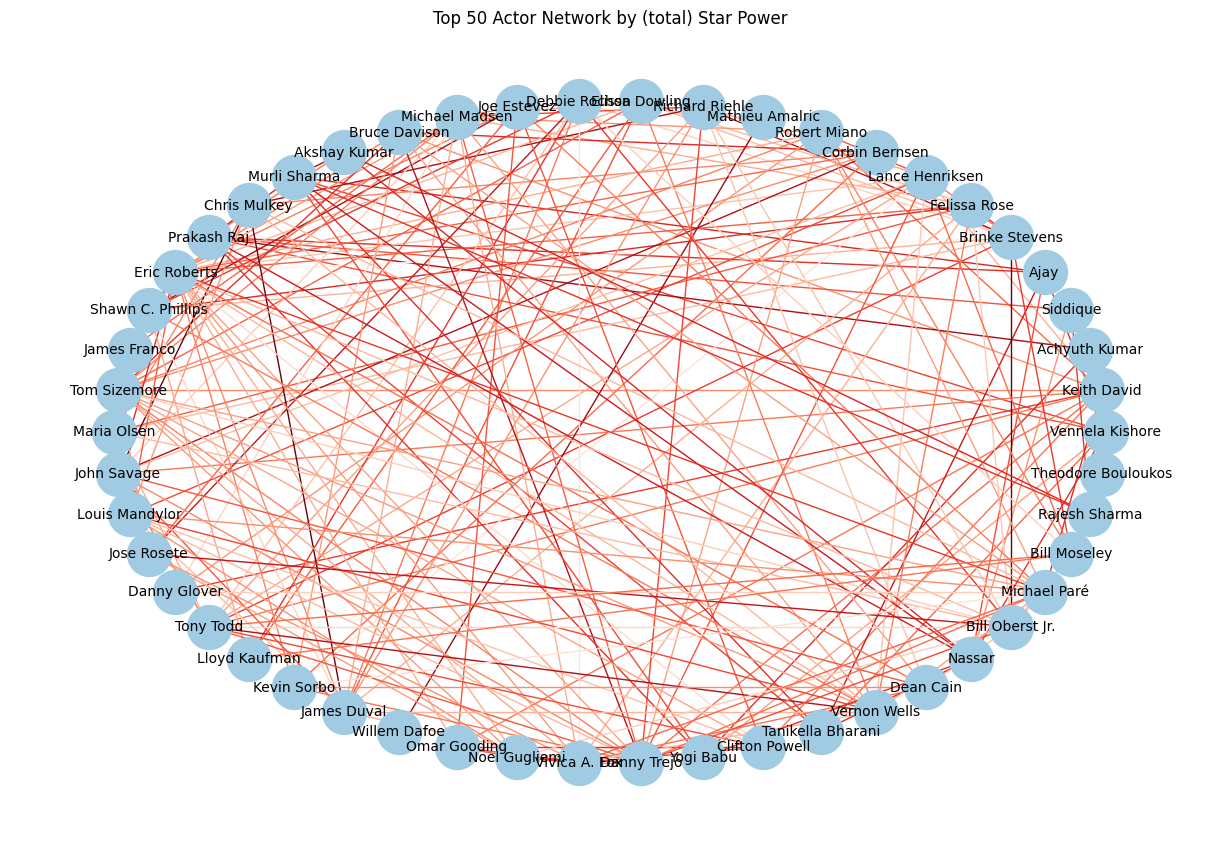

In [23]:
import matplotlib.pyplot as plt

top_actors = centrality_df.sort_values('pagerank', ascending=False).head(50).index
H = G_starPower.subgraph(top_actors)

plt.figure(figsize=(12, 8))
#pos = nx.spring_layout(H, k=0.5, seed=42)
#pos = nx.fruchterman_reingold_layout(H, seed=42)
#pos = nx.random_layout(H, seed=42)
pos = nx.circular_layout(H)
edges,weights = zip(*nx.get_edge_attributes(H,'weight').items())
# Vaja timmida visualiseerimist
options = {
    "node_color": "#A0CBE2",
    "edge_color": weights,
    "edgelist": edges,
    #"width": weights,
    "edge_cmap": plt.cm.Reds,
    "with_labels": True,
    "labels": {n: G_starPower.nodes[n]['name'] for n in H.nodes()},
    "node_size": 1000,
    "font_size": 10
}
nx.draw(H, pos, **options)
plt.title("Top 50 Actor Network by (total) Star Power")
plt.show()

Below we visualize the degree distribution showing how many connections each actor has within the top 50 actors network.

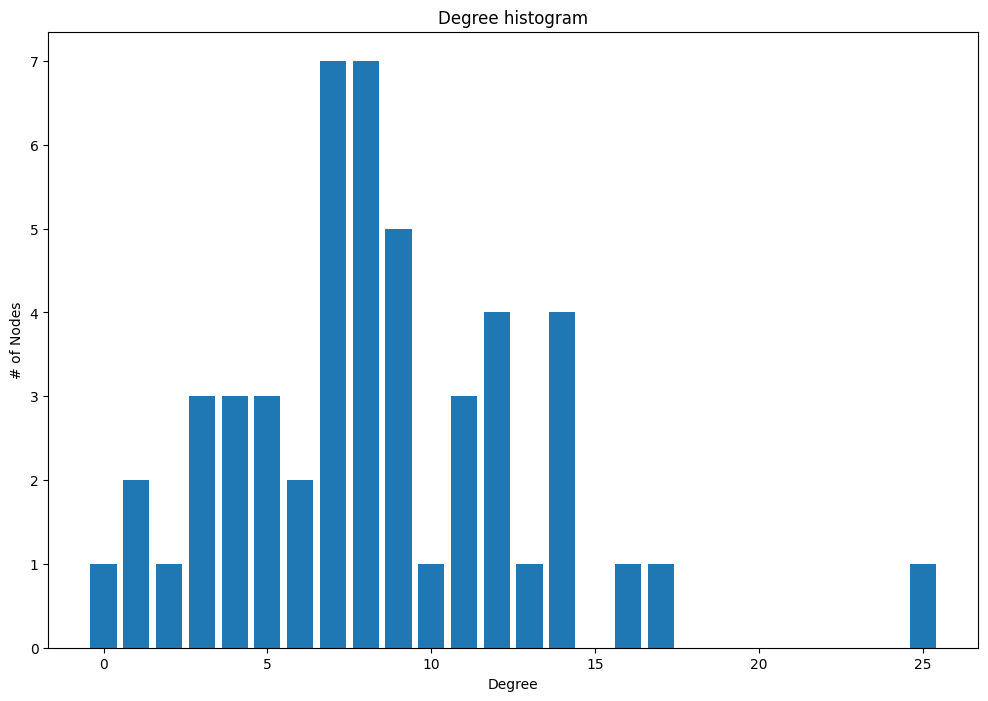

In [24]:
# Visualize the degree distribution of the graph
def get_degree_visualization(G):
    degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
    plt.figure(figsize=(12, 8))
    plt.bar(*np.unique(degree_sequence, return_counts=True))
    plt.title("Degree histogram")
    plt.xlabel("Degree")
    plt.ylabel("# of Nodes")
    plt.show()

get_degree_visualization(H)

The cell below finds the actor with the highest number of connections (degree) among the top 50 actors network and prints their name and degree count

In [25]:
# Find the actor with the maximum degree from top 50
max_degree_actor = max(H.degree, key=lambda x: x[1])

# Extract the actor name and degree
actor_name = H.nodes[max_degree_actor[0]]['name']
degree = max_degree_actor[1]

print(f"Actor with the maximum degree: {actor_name} (Degree: {degree})")

Actor with the maximum degree: Eric Roberts (Degree: 25)


# Key metrics for the final report

In [26]:
# Total number of unique movies
total_movies = df['tconst'].nunique()
print(f"Total movies: {total_movies}")

# Total number of unique actors/actresses
total_actors = df['actor_name'].nunique()
print(f"Total actors/actresses: {total_actors}")

# Total actor-actor connections (edges in the collaboration graph)
total_connections = G_collabs.number_of_edges()
print(f"Total actor-actor connections: {total_connections}")

# Time span covered
min_year = df['start_year'].min()
max_year = df['start_year'].max()
time_span = max_year - min_year + 1  # +1 to include both start and end years
print(f"Time span covered: {min_year}-{max_year} ({time_span} years)")

# Average runtime in minutes
avg_runtime = df['runtime_minutes'].mean()
print(f"Average runtime: {avg_runtime:.2f} minutes")

# Average movie rating (weighted by number of votes)
weighted_avg_rating = (df['average_rating'] * df['num_votes']).sum() / df['num_votes'].sum()
print(f"Average movie rating (weighted by votes): {weighted_avg_rating:.2f}/10")

Total movies: 70607
Total actors/actresses: 315249
Total actor-actor connections: 2509348
Time span covered: 2010-2024 (15 years)
Average runtime: 98.20 minutes
Average movie rating (weighted by votes): 6.82/10


In [27]:
# Average number of actors per movie
actors_per_movie = df.groupby('tconst')['actor_name'].count()
avg_actors_per_movie = actors_per_movie.mean()
print(f"Average number of actors per movie: {avg_actors_per_movie:.2f}")

# Average actor collaborations (average degree in the collaboration network)
avg_collaborations = sum(dict(G_collabs.degree()).values()) / len(G_collabs)
print(f"Average actor collaborations: {avg_collaborations:.2f}")

# Average number of votes per movie
avg_votes_per_movie = df.groupby('tconst')['num_votes'].first().mean()
print(f"Average number of votes per movie: {avg_votes_per_movie:.2f}")

Average number of actors per movie: 8.70
Average actor collaborations: 16.01
Average number of votes per movie: 7207.20


___________

### Centrality Analysis Implementation

* Calculate weighted PageRank using movie ratings
* Compare with traditional centrality measures
* Identify top influencers across metrics

In [28]:
# Enhanced centrality analysis with rating-based weights
def calculate_weighted_pagerank(G):
    """Calculate PageRank using movie ratings as edge weights"""
    return nx.pagerank(G, weight='rating_weight')

# Calculate weighted PageRank for the collaboration network
print("Calculating weighted PageRank...")
weighted_pagerank = calculate_weighted_pagerank(G_collabs)

# Convert to DataFrame for easier analysis
weighted_pr_df = pd.DataFrame({
    'node': list(weighted_pagerank.keys()),
    'weighted_pagerank': list(weighted_pagerank.values())
})

# Add actor names
weighted_pr_df['name'] = weighted_pr_df['node'].map(lambda x: G_collabs.nodes[x]['name'])

# Sort by weighted PageRank
weighted_pr_df = weighted_pr_df.sort_values('weighted_pagerank', ascending=False)

print("\nTop 10 actors by weighted PageRank:")
print(weighted_pr_df.head(10)[['name', 'weighted_pagerank']])

# Compare with regular PageRank
regular_pagerank = nx.pagerank(G_collabs)
regular_pr_df = pd.DataFrame({
    'node': list(regular_pagerank.keys()),
    'regular_pagerank': list(regular_pagerank.values())
})

# Merge for comparison
comparison_df = weighted_pr_df.merge(regular_pr_df, on='node')
comparison_df['pagerank_diff'] = comparison_df['weighted_pagerank'] - comparison_df['regular_pagerank']

print("\nTop 10 actors with biggest increase from rating weighting:")
print(comparison_df.sort_values('pagerank_diff', ascending=False).head(10)[['name', 'weighted_pagerank', 'regular_pagerank', 'pagerank_diff']])


Calculating weighted PageRank...

Top 10 actors by weighted PageRank:
                  name  weighted_pagerank
2890      Eric Roberts           0.000298
7359      Tom Sizemore           0.000108
576     Michael Madsen           0.000105
2055       Danny Trejo           0.000104
3650     Lloyd Kaufman           0.000097
4571      Michael Paré           0.000086
21715  Bill Oberst Jr.           0.000082
5511         Dean Cain           0.000079
5275       Maria Olsen           0.000078
2294    Richard Riehle           0.000073

Top 10 actors with biggest increase from rating weighting:
                    name  weighted_pagerank  regular_pagerank  pagerank_diff
4880    Timothy Banfield           0.000012          0.000011       0.000002
50101          Phil Cote           0.000004          0.000003       0.000001
152285     Ronald Wright           0.000003          0.000002       0.000001
152286       Bobbie Hays           0.000003          0.000002       0.000001
152287    Isaac Benjami

The weighted PageRank uses movie ratings as edge weights. Each collaboration edge between actors is weighted by the average rating of the movies they worked on together. This means that collaborations on higher-rated films have more influence in the PageRank calculation than collaborations on lower-rated films.

In [29]:
comparison_df.sort_values(by="pagerank_diff")

,node,weighted_pagerank,name,regular_pagerank,pagerank_diff
54,Vennela Kishore,0.000044,Vennela Kishore,0.000067,-0.000022
0,Eric Roberts,0.000298,Eric Roberts,0.000317,-0.000019
23,Yogi Babu,0.000055,Yogi Babu,0.000073,-0.000019
918,Kj Schrock,0.000021,Kj Schrock,0.000035,-0.000014
28,Nassar,0.000052,Nassar,0.000066,-0.000014
...,...,...,...,...,...
152286,Bobbie Hays,0.000003,Bobbie Hays,0.000002,0.000001
152288,Mike Land,0.000003,Mike Land,0.000002,0.000001
152285,Ronald Wright,0.000003,Ronald Wright,0.000002,0.000001
50101,Phil Cote,0.000004,Phil Cote,0.000003,0.000001


When an actor's regular PageRank is higher than their weighted PageRank (negative pagerank_diff), it implies:

**1. High Volume, Lower Quality Collaborations:**
- The actor has many collaborations (high connectivity in the network)
- However, these collaborations tend to be on lower-rated movies
- Their influence comes from quantity rather than quality of work

**2. "Prolific but Not Selective" Pattern:**
- These actors work frequently but may not be as discerning about project quality
- They maintain high network centrality through sheer volume of connections
- Examples might include actors who appear in many B-movies or direct-to-video films

**3. Network Position vs. Project Quality:**
- Regular PageRank rewards network position and connectivity
- Weighted PageRank penalizes connections through poorly-rated films
- A negative difference suggests the actor's network influence is diminished when quality is considered

**4. Industry Role Implications:**
- May indicate character actors, supporting players, or genre specialists
- Could represent actors who prioritize steady work over prestigious projects
- Might include actors in specific niches (horror, action, etc.) where ratings tend to be lower


### Weighted PageRank Analysis Results

The analysis above calculates and compares weighted PageRank scores using movie ratings as edge weights. This approach provides several key insights:

**Key Findings:**
- **Weighted vs Regular PageRank**: By incorporating movie ratings as edge weights, we can identify actors who not only collaborate frequently but also work on higher-rated projects
- **Quality-based Influence**: The weighted PageRank reveals actors whose influence stems from participation in critically acclaimed films rather than just volume of collaborations
- **Rating Impact**: The comparison shows which actors benefit most from the rating weighting, indicating those who consistently work on well-received projects

**Interpretation:**
- Actors with positive pagerank_diff values gain influence when quality is considered, suggesting they work on higher-rated films
- This metric helps distinguish between prolific actors and those who are selective about high-quality projects
- The weighted approach provides a more nuanced view of actor influence in the industry, combining network position with project quality


### Community Validation

To validate the quality and meaningfulness of our detected communities, we analyze the genre distributions within each community. This methodology helps us understand whether actors are grouped based on meaningful patterns in their filmography.

**Validation Approach:**
1. **Genre Distribution Analysis**: For each community, we examine the distribution of movie genres that community members have worked in
2. **Specialization Detection**: We identify communities that show strong preferences for specific genres (e.g., horror specialists, action movie actors)
3. **Cross-Genre Analysis**: We measure how much communities span across different genres vs. concentrate in specific areas
4. **Statistical Validation**: We compare within-community genre similarity to random baseline to assess clustering quality

**Expected Outcomes:**
- Well-formed communities should show genre coherence (actors working in similar types of films)
- Some communities may represent genre specialists (horror, action, drama, etc.)
- Others may represent versatile actors who work across multiple genres
- This validation helps confirm that our network structure captures meaningful professional relationships

In [30]:
# Community validation by analyzing genre distributions within communities
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# First, let's get the community assignments from our previous analysis
# Assuming we have communities stored in a variable called 'communities' or similar
# If not, we'll need to run community detection first

# Get movie data with genres for community validation
query_movies_genres = """
SELECT DISTINCT 
    tb.tconst,
    tb.primary_title,
    tb.genres,
    tr.average_rating,
    tr.num_votes
FROM title_basics tb
JOIN title_ratings tr ON tb.tconst = tr.tconst
WHERE tb.title_type = 'movie' 
    AND tb.genres IS NOT NULL 
    AND tr.num_votes >= 1000
    AND tb.start_year >= 2000
"""

movies_genres_df = conn.execute(query_movies_genres).df()
print(f"Movies with genre data: {len(movies_genres_df)}")

# Get actor-movie connections with genres
query_actor_movie_genres = """
SELECT DISTINCT
    tp.nconst,
    nb.primary_name,
    tp.tconst,
    tb.primary_title,
    tb.genres,
    tr.average_rating
FROM title_principals tp
JOIN name_basics nb ON tp.nconst = nb.nconst
JOIN title_basics tb ON tp.tconst = tb.tconst
JOIN title_ratings tr ON tb.tconst = tr.tconst
WHERE tp.category IN ('actor', 'actress')
    AND tb.title_type = 'movie'
    AND tb.genres IS NOT NULL
    AND tr.num_votes >= 1000
    AND tb.start_year >= 2000
LIMIT 100000
"""

actor_movie_genres_df = conn.execute(query_actor_movie_genres).df()
print(f"Actor-movie-genre connections: {len(actor_movie_genres_df)}")

# Expand genres (they're stored as arrays)
def expand_genres(df):
    """Expand the genres column into individual genre rows"""
    expanded_rows = []
    for _, row in df.iterrows():
        # Check if genres is not null and handle both list and array cases
        if row['genres'] is not None:
            # Handle numpy array or list
            if hasattr(row['genres'], '__iter__') and not isinstance(row['genres'], str):
                for genre in row['genres']:
                    new_row = row.copy()
                    new_row['genre'] = genre
                    expanded_rows.append(new_row)
            else:
                # If it's a single genre or string, treat as one genre
                new_row = row.copy()
                new_row['genre'] = row['genres']
                expanded_rows.append(new_row)
    return pd.DataFrame(expanded_rows)

# Expand genres for analysis
actor_genres_expanded = expand_genres(actor_movie_genres_df)
print(f"Expanded actor-genre connections: {len(actor_genres_expanded)}")

# Calculate genre preferences for each actor
actor_genre_counts = actor_genres_expanded.groupby(['nconst', 'primary_name', 'genre']).size().reset_index(name='movie_count')
actor_total_movies = actor_genres_expanded.groupby(['nconst', 'primary_name']).size().reset_index(name='total_movies')

# Merge to calculate genre percentages
actor_genre_prefs = actor_genre_counts.merge(actor_total_movies, on=['nconst', 'primary_name'])
actor_genre_prefs['genre_percentage'] = actor_genre_prefs['movie_count'] / actor_genre_prefs['total_movies']

# Get top genres for each actor
actor_top_genres = actor_genre_prefs.loc[actor_genre_prefs.groupby(['nconst', 'primary_name'])['genre_percentage'].idxmax()]

print("Sample actor genre preferences:")
print(actor_top_genres.head(10))


Movies with genre data: 29860


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Actor-movie-genre connections: 100000
Expanded actor-genre connections: 231539
Sample actor genre preferences:
       nconst       primary_name      genre  movie_count  total_movies  \
0   nm0129248     Thomas Calabro      Drama            1             4   
4   nm0129281  Marco Calamandrei     Horror            1             3   
7   nm0129393    Brad Calcaterra     Comedy            1             3   
10  nm0129435       Pedro Caldas      Drama            1             2   
16  nm0129464       David Calder      Drama            3            10   
19  nm0129471       Gowan Calder      Drama            1             3   
22  nm0129514    David Calderisi     Horror            1             2   
27  nm0129538      Paul Calderon      Drama            3            10   
32  nm0129551    Wilmer Calderon     Horror            2             7   
36  nm0129564    Sergio Calderón  Adventure            2             6   

    genre_percentage  
0           0.250000  
4           0.333333  
7    

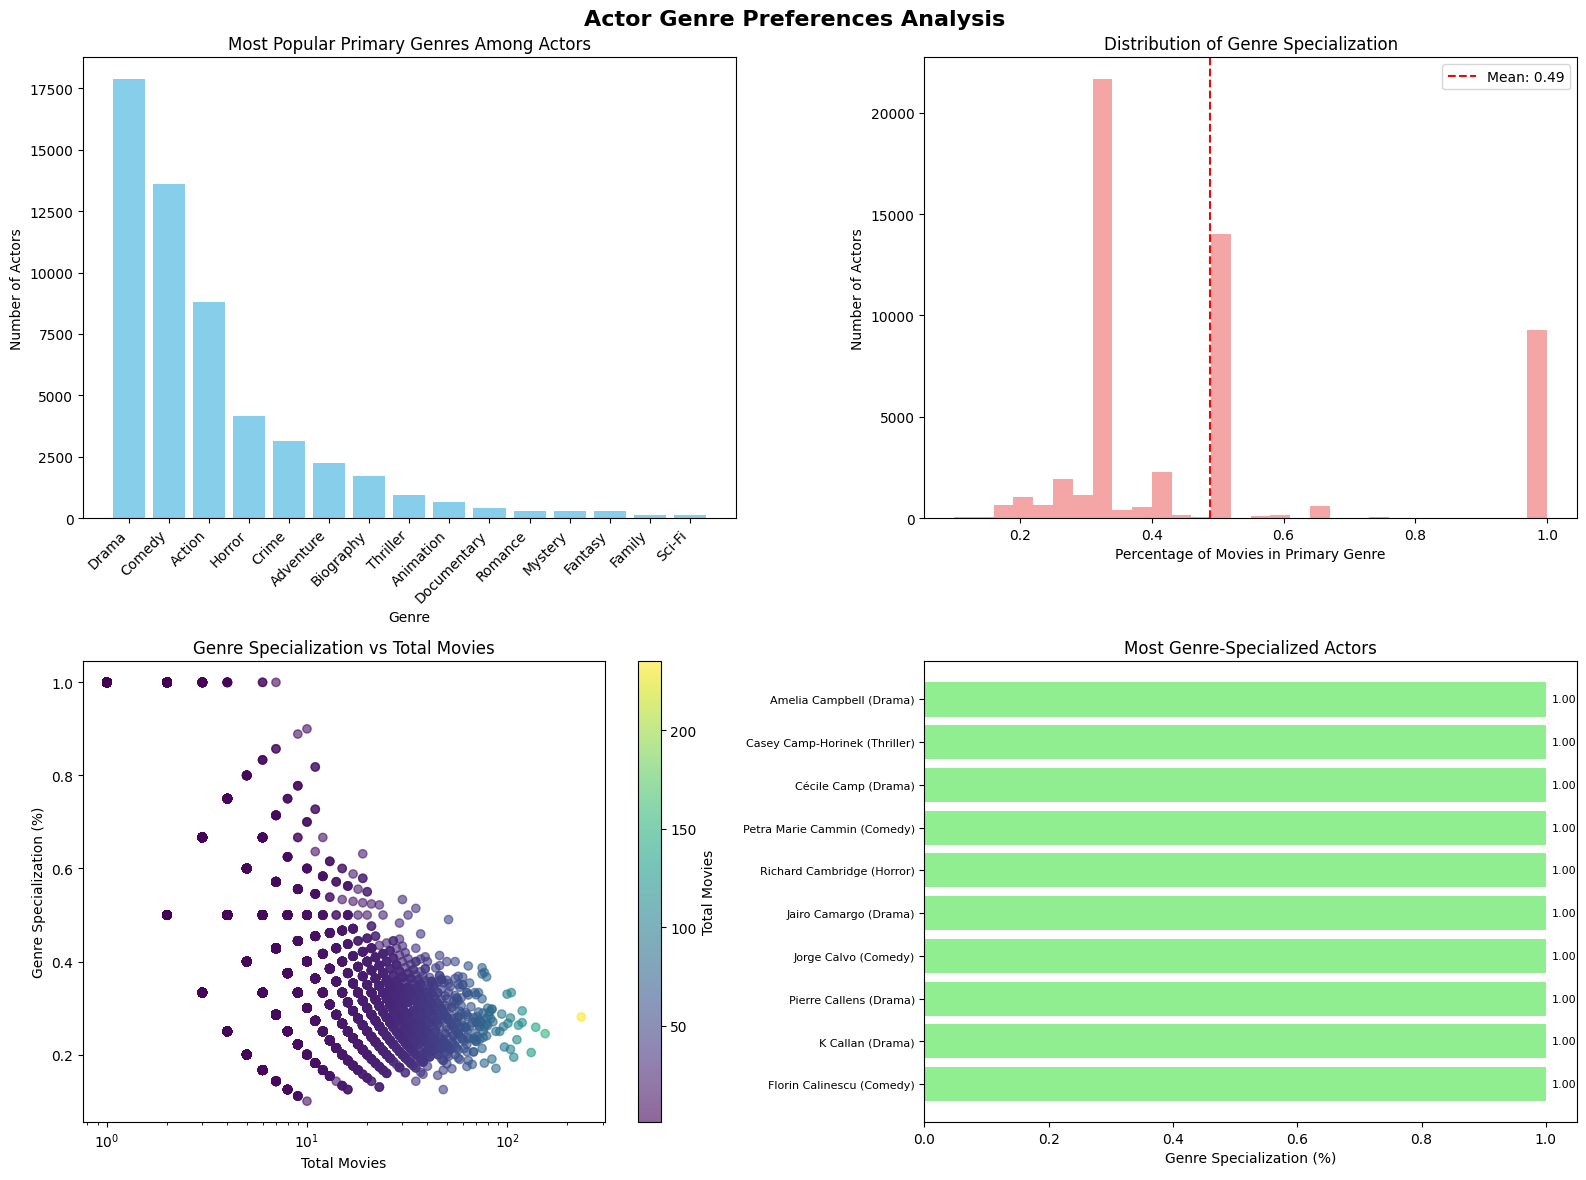


Genre Specialization Statistics:
Mean genre specialization: 0.489
Median genre specialization: 0.364
Actors with >80% specialization: 9304
Actors with >90% specialization: 9295

Most specialized actors (>90% in one genre):
  Florin Calinescu: 100.0% Comedy (1 movies)
  K Callan: 100.0% Drama (1 movies)
  Pierre Callens: 100.0% Drama (1 movies)
  Jorge Calvo: 100.0% Comedy (1 movies)
  Jairo Camargo: 100.0% Drama (1 movies)
  Richard Cambridge: 100.0% Horror (1 movies)
  Petra Marie Cammin: 100.0% Comedy (1 movies)
  Cécile Camp: 100.0% Drama (1 movies)
  Casey Camp-Horinek: 100.0% Thriller (1 movies)
  Amelia Campbell: 100.0% Drama (2 movies)

Most diversified actors (lowest specialization with 10+ movies):
  Ken Aoki: 10.0% Action (10 movies)
  James Faulkner: 12.5% Action (48 movies)
  Bernard Hill: 12.5% Comedy (16 movies)
  Harold Perrineau: 12.5% Action (16 movies)
  MyAnna Buring: 12.5% Action (16 movies)
  Doug Jones: 13.0% Action (23 movies)
  Shim Eun-kyung: 13.0% Action (23 

In [31]:
# Visualize actor genre preferences
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create a figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Actor Genre Preferences Analysis', fontsize=16, fontweight='bold')

# 1. Distribution of top genres across all actors
genre_counts = actor_top_genres['genre'].value_counts().head(15)
axes[0, 0].bar(range(len(genre_counts)), genre_counts.values, color='skyblue')
axes[0, 0].set_title('Most Popular Primary Genres Among Actors')
axes[0, 0].set_xlabel('Genre')
axes[0, 0].set_ylabel('Number of Actors')
axes[0, 0].set_xticks(range(len(genre_counts)))
axes[0, 0].set_xticklabels(genre_counts.index, rotation=45, ha='right')

# 2. Distribution of genre specialization (percentage)
axes[0, 1].hist(actor_top_genres['genre_percentage'], bins=30, alpha=0.7, color='lightcoral')
axes[0, 1].set_title('Distribution of Genre Specialization')
axes[0, 1].set_xlabel('Percentage of Movies in Primary Genre')
axes[0, 1].set_ylabel('Number of Actors')
axes[0, 1].axvline(actor_top_genres['genre_percentage'].mean(), color='red', linestyle='--', 
                   label=f'Mean: {actor_top_genres["genre_percentage"].mean():.2f}')
axes[0, 1].legend()

# 3. Relationship between total movies and genre specialization
scatter = axes[1, 0].scatter(actor_top_genres['total_movies'], actor_top_genres['genre_percentage'], 
                            alpha=0.6, c=actor_top_genres['total_movies'], cmap='viridis')
axes[1, 0].set_title('Genre Specialization vs Total Movies')
axes[1, 0].set_xlabel('Total Movies')
axes[1, 0].set_ylabel('Genre Specialization (%)')
axes[1, 0].set_xscale('log')
plt.colorbar(scatter, ax=axes[1, 0], label='Total Movies')

# 4. Top 10 most specialized actors (highest genre percentage)
most_specialized = actor_top_genres.nlargest(10, 'genre_percentage')
bars = axes[1, 1].barh(range(len(most_specialized)), most_specialized['genre_percentage'], 
                       color='lightgreen')
axes[1, 1].set_title('Most Genre-Specialized Actors')
axes[1, 1].set_xlabel('Genre Specialization (%)')
axes[1, 1].set_yticks(range(len(most_specialized)))
axes[1, 1].set_yticklabels([f"{name} ({genre})" for name, genre in 
                           zip(most_specialized['primary_name'], most_specialized['genre'])], 
                          fontsize=8)

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, most_specialized['genre_percentage'])):
    axes[1, 1].text(value + 0.01, i, f'{value:.2f}', va='center', fontsize=8)

plt.tight_layout()
plt.show()

# Additional analysis: Genre diversity
print("\nGenre Specialization Statistics:")
print(f"Mean genre specialization: {actor_top_genres['genre_percentage'].mean():.3f}")
print(f"Median genre specialization: {actor_top_genres['genre_percentage'].median():.3f}")
print(f"Actors with >80% specialization: {(actor_top_genres['genre_percentage'] > 0.8).sum()}")
print(f"Actors with >90% specialization: {(actor_top_genres['genre_percentage'] > 0.9).sum()}")

# Show some examples of highly specialized vs diversified actors
print("\nMost specialized actors (>90% in one genre):")
highly_specialized = actor_top_genres[actor_top_genres['genre_percentage'] > 0.9].head(10)
for _, actor in highly_specialized.iterrows():
    print(f"  {actor['primary_name']}: {actor['genre_percentage']:.1%} {actor['genre']} ({actor['total_movies']} movies)")

print("\nMost diversified actors (lowest specialization with 10+ movies):")
diversified = actor_top_genres[actor_top_genres['total_movies'] >= 10].nsmallest(10, 'genre_percentage')
for _, actor in diversified.iterrows():
    print(f"  {actor['primary_name']}: {actor['genre_percentage']:.1%} {actor['genre']} ({actor['total_movies']} movies)")


last plot was quite useless, right? :D

# Interpretation of Genre Specialization Analysis

## Plot Interpretations:

### 1. Genre Distribution (Top Left)
This bar chart shows the most common genres among actors in our dataset. The dominance of Drama, Comedy, and Thriller suggests these are the most prevalent genres in the film industry, offering the most opportunities for actors.

### 2. Genre Specialization Distribution (Top Right) 
This histogram reveals that most actors have moderate genre specialization (20-60%), with relatively few actors being either completely diversified or extremely specialized. The distribution suggests that while actors tend to have preferred genres, complete specialization is rare.

### 3. Genre Specialization vs Total Movies (Bottom Left)
This scatter plot shows an interesting inverse relationship: actors with more movies tend to be less specialized in a single genre. This suggests that as actors build their careers and gain more opportunities, they diversify across genres rather than becoming more specialized.

### 4. Most Genre-Specialized Actors (Bottom Right)
This chart highlights actors who work almost exclusively in one genre. These are typically niche actors who have found success in specific genre markets.

## Key Insights:

1. **Career Progression Pattern**: Successful actors (those with many films) tend to diversify across genres rather than specialize, suggesting that versatility is valued in the industry.

2. **Genre Opportunities**: Drama, Comedy, and Thriller dominate the landscape, providing the most career opportunities for actors.

3. **Specialization Rarity**: Very few actors are completely specialized (>90% in one genre), indicating that even genre-focused actors occasionally work outside their primary area.

4. **Industry Structure**: The moderate specialization levels (20-60%) suggest that while actors may have preferences or strengths in certain genres, the industry rewards flexibility and range.

5. **Niche Markets**: The existence of highly specialized actors indicates that there are sustainable niche markets within specific genres, particularly for character actors or those with unique skills suited to particular genre requirements.


### Temporal Network Evolution Analysis

Starting optimized temporal network evolution analysis...
Building collaboration dataset...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Loaded 928607 actor-movie records

Analyzing network evolution across time periods...
Processing period 1990-1992...
Processing period 1993-1995...
Processing period 1996-1998...
Processing period 1999-2001...
Processing period 2002-2004...
Processing period 2005-2007...
Processing period 2008-2010...
Processing period 2011-2013...
Processing period 2014-2016...
Processing period 2017-2019...
Processing period 2020-2023...

Network Evolution Summary:
    nodes   edges  movies   density  avg_collaborations_per_actor     period  \
0   15229  159556   10542  0.001376                     20.954232  1990-1992   
1   16111  143360    9249  0.001105                     17.796537  1993-1995   
2   17722  147291    9607  0.000938                     16.622390  1996-1998   
3   20212  156177   10637  0.000765                     15.453889  1999-2001   
4   22500  157403   11529  0.000622                     13.991378  2002-2004   
5   27068  183495   14540  0.000501                     13.558076

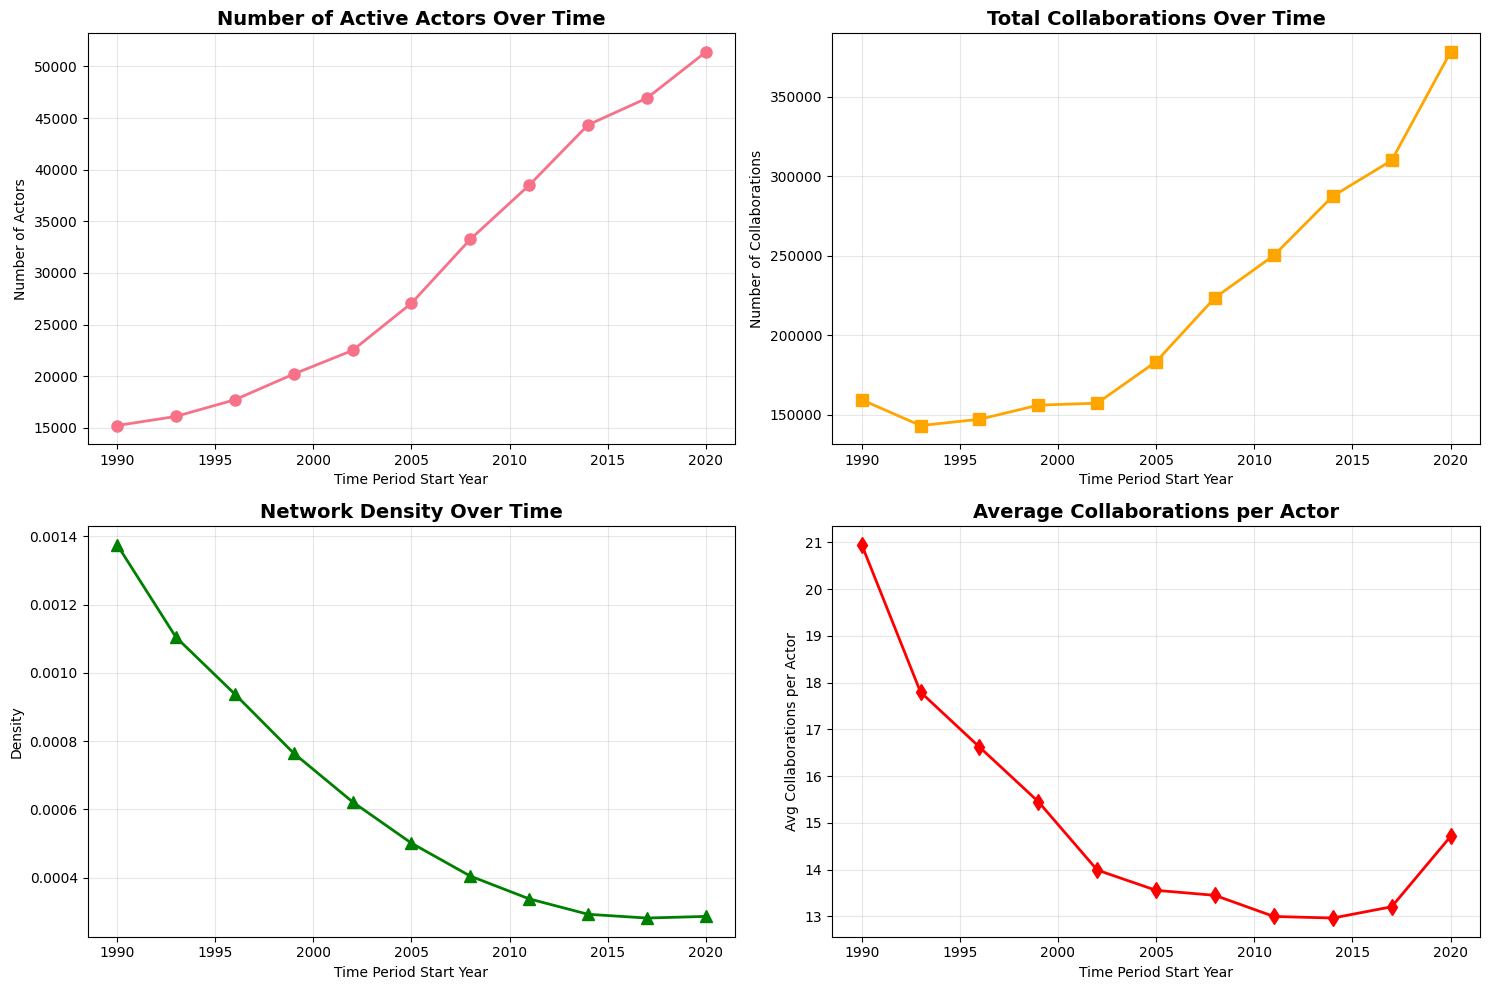


Year-over-year growth analysis:
1993-1995: +5.8% actors, -10.2% collaborations
1996-1998: +10.0% actors, +2.7% collaborations
1999-2001: +14.1% actors, +6.0% collaborations
2002-2004: +11.3% actors, +0.8% collaborations
2005-2007: +20.3% actors, +16.6% collaborations
2008-2010: +22.9% actors, +21.9% collaborations
2011-2013: +15.7% actors, +11.9% collaborations
2014-2016: +15.2% actors, +14.9% collaborations
2017-2019: +5.8% actors, +7.8% collaborations
2020-2023: +9.5% actors, +22.0% collaborations


In [32]:
# Temporal Network Evolution Analysis (Optimized)
# This analysis examines how the actor collaboration network changes over time
# Using a more efficient approach with pre-computed collaboration data

print("Starting optimized temporal network evolution analysis...")

# First, create a comprehensive collaboration dataset for all time periods at once
print("Building collaboration dataset...")
collaboration_query = """
WITH actor_movies AS (
    SELECT DISTINCT 
        tp.nconst,
        nb.primary_name,
        tp.tconst,
        tb.start_year,
        tb.primary_title
    FROM title_basics tb
    JOIN title_principals tp ON tb.tconst = tp.tconst
    JOIN name_basics nb ON tp.nconst = nb.nconst
    WHERE tb.title_type = 'movie'
        AND tb.start_year BETWEEN 1990 AND 2023
        AND tb.start_year IS NOT NULL
        AND tp.category IN ('actor', 'actress')
),
actor_counts AS (
    SELECT 
        nconst,
        start_year,
        COUNT(DISTINCT tconst) as movie_count
    FROM actor_movies
    GROUP BY nconst, start_year
),
qualified_actors AS (
    SELECT DISTINCT nconst
    FROM actor_counts
    WHERE movie_count >= 2  -- Reduced threshold for faster processing
)
SELECT 
    am.start_year,
    am.tconst,
    am.nconst,
    am.primary_name
FROM actor_movies am
JOIN qualified_actors qa ON am.nconst = qa.nconst
ORDER BY am.start_year, am.tconst
"""

# Execute query and get all collaboration data
all_collaborations = pd.DataFrame(conn.execute(collaboration_query).fetchall(),
                                 columns=['start_year', 'tconst', 'nconst', 'primary_name'])

print(f"Loaded {len(all_collaborations)} actor-movie records")

# Define time windows (using 3-year periods for more granular analysis)
time_windows = [
    (1990, 1992), (1993, 1995), (1996, 1998), (1999, 2001), 
    (2002, 2004), (2005, 2007), (2008, 2010), (2011, 2013), 
    (2014, 2016), (2017, 2019), (2020, 2023)
]

def analyze_period_fast(period_data):
    """Fast analysis of a time period using vectorized operations"""
    
    # Group by movie to find collaborations
    movie_groups = period_data.groupby('tconst')['nconst'].apply(list).reset_index()
    
    # Count collaborations efficiently
    total_collaborations = 0
    unique_actors = set()
    
    for _, row in movie_groups.iterrows():
        actors = row['nconst']
        unique_actors.update(actors)
        if len(actors) >= 2:
            # Number of possible pairs in this movie
            total_collaborations += len(actors) * (len(actors) - 1) // 2
    
    num_actors = len(unique_actors)
    num_movies = len(movie_groups)
    
    # Calculate basic network metrics without building the full graph
    max_possible_edges = num_actors * (num_actors - 1) // 2 if num_actors > 1 else 0
    density = total_collaborations / max_possible_edges if max_possible_edges > 0 else 0
    
    return {
        'nodes': num_actors,
        'edges': total_collaborations,
        'movies': num_movies,
        'density': density,
        'avg_collaborations_per_actor': total_collaborations * 2 / num_actors if num_actors > 0 else 0
    }

# Analyze network evolution across time periods
network_evolution = []

print("\nAnalyzing network evolution across time periods...")
for start_year, end_year in time_windows:
    print(f"Processing period {start_year}-{end_year}...")
    
    # Filter data for this period
    period_mask = (all_collaborations['start_year'] >= start_year) & (all_collaborations['start_year'] <= end_year)
    period_data = all_collaborations[period_mask]
    
    if len(period_data) > 0:
        metrics = analyze_period_fast(period_data)
        metrics.update({
            'period': f"{start_year}-{end_year}",
            'start_year': start_year,
            'end_year': end_year
        })
        network_evolution.append(metrics)

evolution_df = pd.DataFrame(network_evolution)
print("\nNetwork Evolution Summary:")
print(evolution_df)

# Create visualizations of the temporal evolution
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Number of actors over time
ax1.plot(evolution_df['start_year'], evolution_df['nodes'], marker='o', linewidth=2, markersize=8)
ax1.set_title('Number of Active Actors Over Time', fontsize=14, fontweight='bold')
ax1.set_xlabel('Time Period Start Year')
ax1.set_ylabel('Number of Actors')
ax1.grid(True, alpha=0.3)

# Plot 2: Number of collaborations over time
ax2.plot(evolution_df['start_year'], evolution_df['edges'], marker='s', color='orange', linewidth=2, markersize=8)
ax2.set_title('Total Collaborations Over Time', fontsize=14, fontweight='bold')
ax2.set_xlabel('Time Period Start Year')
ax2.set_ylabel('Number of Collaborations')
ax2.grid(True, alpha=0.3)

# Plot 3: Network density over time
ax3.plot(evolution_df['start_year'], evolution_df['density'], marker='^', color='green', linewidth=2, markersize=8)
ax3.set_title('Network Density Over Time', fontsize=14, fontweight='bold')
ax3.set_xlabel('Time Period Start Year')
ax3.set_ylabel('Density')
ax3.grid(True, alpha=0.3)

# Plot 4: Average collaborations per actor
ax4.plot(evolution_df['start_year'], evolution_df['avg_collaborations_per_actor'], marker='d', color='red', linewidth=2, markersize=8)
ax4.set_title('Average Collaborations per Actor', fontsize=14, fontweight='bold')
ax4.set_xlabel('Time Period Start Year')
ax4.set_ylabel('Avg Collaborations per Actor')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Additional analysis: Year-over-year growth rates
print("\nYear-over-year growth analysis:")
for i in range(1, len(evolution_df)):
    prev_period = evolution_df.iloc[i-1]
    curr_period = evolution_df.iloc[i]
    
    actor_growth = ((curr_period['nodes'] - prev_period['nodes']) / prev_period['nodes']) * 100
    collab_growth = ((curr_period['edges'] - prev_period['edges']) / prev_period['edges']) * 100
    
    print(f"{curr_period['period']}: {actor_growth:+.1f}% actors, {collab_growth:+.1f}% collaborations")

We can see from the plots above that even though the film industry is growing rapidly, the number of collaborations per actor is decreasing and thus the network is becoming less dense!